#### The CNN32 model

The bigger model will be used later as a teacher model. The model must have a real good accuracy on validation data.

In [1]:
########### Basic Parameters for Running: ################################
    
Training_Percentage = 0.2           
Epoch_Anz = 30                      # earlystopping, see model.fit
nb_classes = 1                     # move to 1. step
#input_shape = (32, 20,1)            # will be calculated
Batch_Size = 32
use_grayscale = False                # grayscale or rgb
model_filename = "output/cnn32-r"

##########################################################################

from sklearn.model_selection import train_test_split
from b2n.data.tmnist import tmnist_percentals
from b2n.data.ziffer import ziffer_data
from b2n.plotfunctions import *
from sklearn.utils import shuffle
from b2n.encodings.linear_encoding import *
from b2n.augmentation.generator import *

try:
    # Disable all GPUS
    tf.config.set_visible_devices([], 'GPU')
    visible_devices = tf.config.get_visible_devices()
    for device in visible_devices:
        assert device.device_type != 'GPU'
except:
    # Invalid device or cannot modify virtual devices once initialized.
    pass

#### 

## Load data

Like the distillation network meter digits will be trained with font builded images.

### digit meter images

The meter digits are all 0-9 ziffer_raw (https://github.com/jomjol/neural-network-autotrain-digital-counter/tree/main/ziffer_raw) and other collected data (used https://github.com/haverland/collectmeterdigits).


### Percental TMNIST

300.000 images of type face fonts in 0.1 steps from 0.0 to 9.9

See https://www.kaggle.com/datasets/frankhaverland/percentile-tmnist-for-electric-meters


### Train and Test data

For 1st train both dataset mixed are used.

### digit meter spread

The percental TMNIST has for every label the same count of data.

The images of digit meters are collected and labeled by hand. So the image count of labels are differnt. The meter digit spread plot shows the count for each label.

Ziffer data count:  12477
(224128, 32, 20, 3)
dataset x_train-size=224128


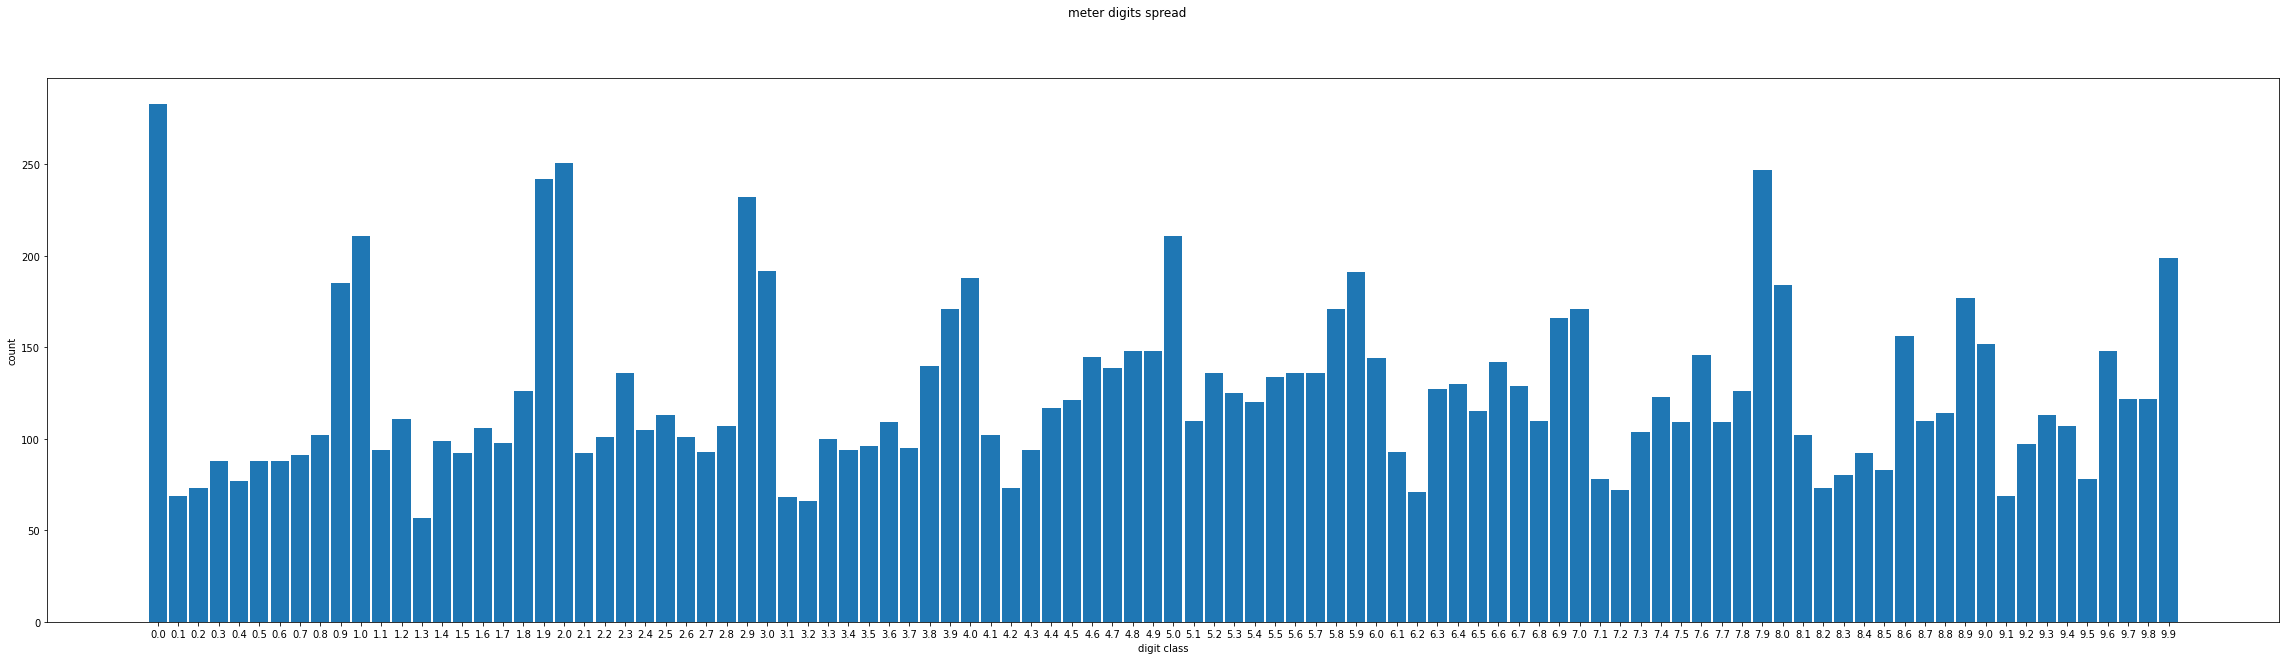

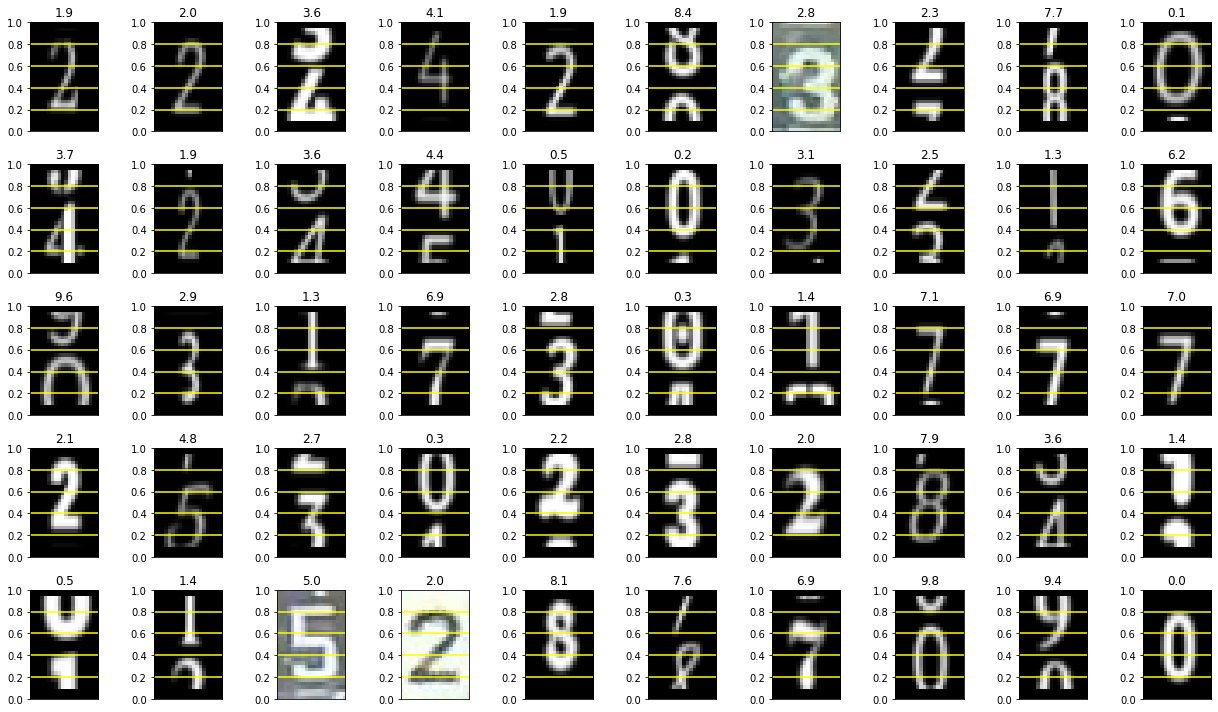

In [2]:
from sklearn.model_selection import train_test_split

xz_data, yz_data, fz_data = ziffer_data(input_dir='images')

# distribution
_, inverse = np.unique(yz_data, return_inverse=True)
ziffer_bincount = np.bincount(inverse)
plot_divergence(ziffer_bincount, "meter digits spread", 100)


# Split train and validation data 
xz_train, yz_train = shuffle(xz_data, yz_data)
xz_train, xz_test, yz_train, yz_test = train_test_split(xz_train, yz_train, test_size=Training_Percentage)


xt_data, yt_data = tmnist_percentals()


x_data = np.concatenate((xt_data, xz_train))
y_data = np.concatenate((yt_data, yz_train))
x_data, y_data = shuffle(x_data, y_data)
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=Training_Percentage)

print(x_train.shape)

input_shape=x_train[0].shape
print(f"dataset x_train-size={len(x_train)}")
plot_dataset(x_train, y_train)

y_train = class_encoding(y_train, nb_classes)
y_test = class_encoding(y_test, nb_classes)

yz_train = class_encoding(yz_train, nb_classes)
yz_test = class_encoding(yz_test, nb_classes)


### Augmentation
See augementation above for augmentation values.
Standard augmentation of image generator is used plus inverting, spot light and noising images.

The validation set is not augmentated. It uses only meter digit images for a real result how the model fits to meter digits.
So the validation says more about the results and its easier to use a early stopping mechanism.

Train data


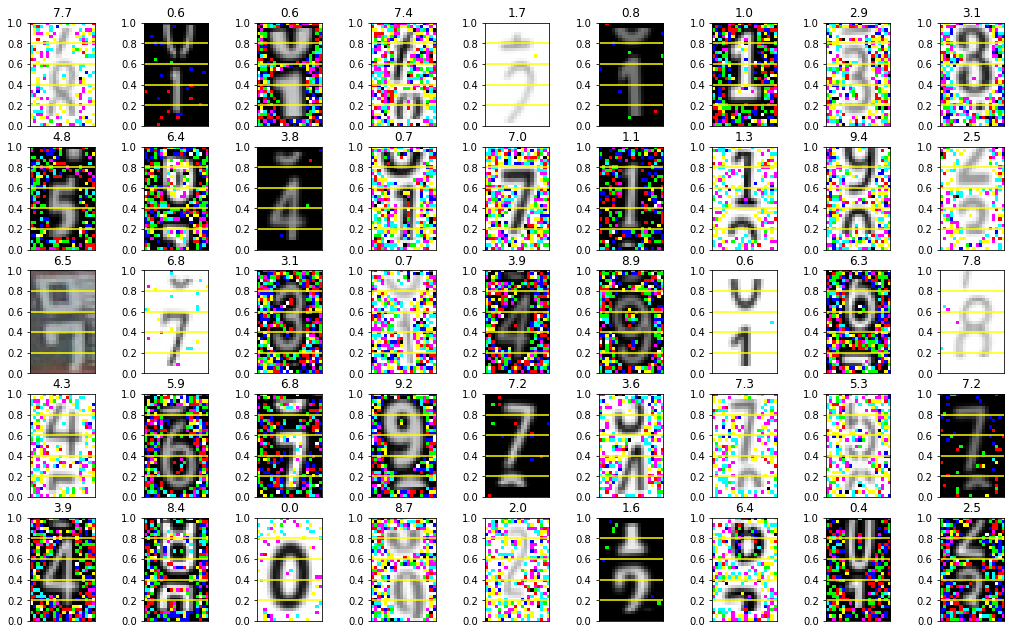

Validation data


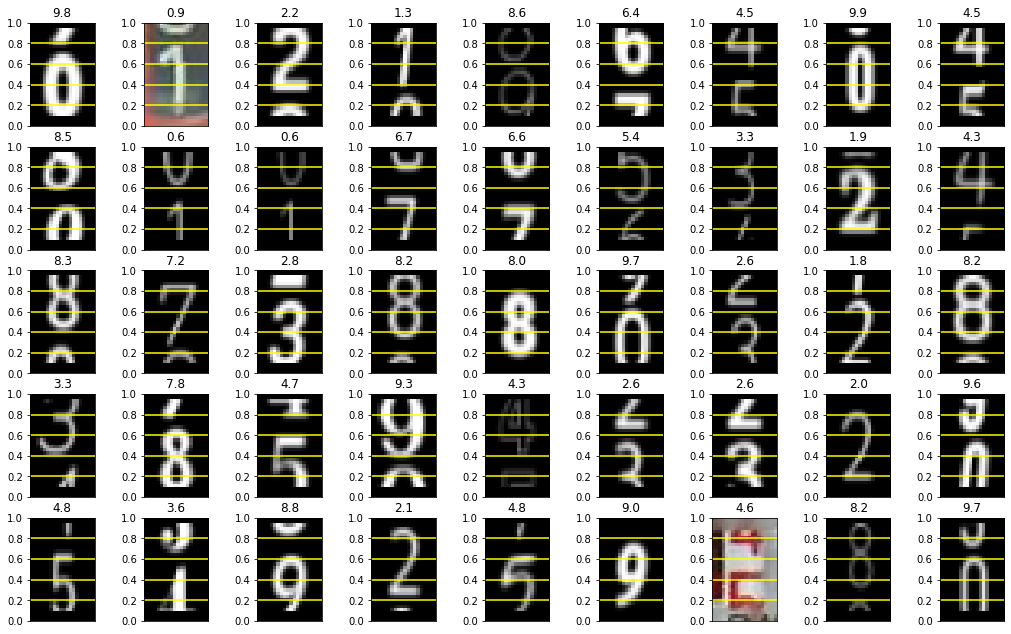

In [3]:
import numpy as np

train_iterator = augmentation(x_train, y_train, preprocessing_function=invert_noise)
validation_iterator = no_augmentation(x_test, y_test)

# train data
print("Train data")
plot_dataset_it(train_iterator, nb_classes=nb_classes, classdecoding=class_decoding)     

# validation data
print("Validation data")
plot_dataset_it(validation_iterator, nb_classes=nb_classes, classdecoding=class_decoding) 


### The Model

Classic CNN model.

In [4]:
import tensorflow as tf
from b2n.models.cnn32 import VGG_like, CNN_s1
from keras.layers import Dense
from keras import backend as K

def soft_acc(y_true, y_pred):
    return K.mean(K.less_equal(K.abs((K.abs(y_true)- K.abs(y_pred))), 0.11 ))


model = keras.models.load_model('output/cnn32_best_transfer.h5')
model = tf.keras.models.Sequential(model.layers[:-3])
for layer in model.layers:
    layer.trainable=False
model.add(Dense(1024, activation='relu',name='relu1' ) )
model.add(Dense(1024, activation='relu',name='relu2' ) )
model.add(Dense(nb_classes, activation='linear', name='top'))


model.summary()
model.compile(loss="mse", 
              optimizer="adam", metrics = [soft_acc])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 20, 32)        896       
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 20, 32)        9248      
                                                                 
 batch_normalization (BatchN  (None, 32, 20, 32)       128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 10, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 16, 10, 32)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 16, 10, 64)        1

### The Training

Standard training of the model with complete dataset.

The ModelCheckpoint helps to keep the best model. 

Epoch 1/30


2022-06-16 00:10:06.699448: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


7003/7004 [============================>.] - ETA: 0s - loss: 0.4901 - soft_acc: 0.3897
Epoch 1: val_soft_acc improved from -inf to 0.52874, saving model to output/cnn32-r_best.h5
7004/7004 [==============================] - 168s 24ms/step - loss: 0.4900 - soft_acc: 0.3898 - val_loss: 0.0512 - val_soft_acc: 0.5287 - lr: 0.0010
Epoch 2/30
7003/7004 [============================>.] - ETA: 0s - loss: 0.1733 - soft_acc: 0.6343
Epoch 2: val_soft_acc improved from 0.52874 to 0.91130, saving model to output/cnn32-r_best.h5
7004/7004 [==============================] - 158s 22ms/step - loss: 0.1732 - soft_acc: 0.6344 - val_loss: 0.0327 - val_soft_acc: 0.9113 - lr: 9.6000e-04
Epoch 3/30
7003/7004 [============================>.] - ETA: 0s - loss: 0.1492 - soft_acc: 0.7057
Epoch 3: val_soft_acc did not improve from 0.91130
7004/7004 [==============================] - 154s 22ms/step - loss: 0.1492 - soft_acc: 0.7058 - val_loss: 0.0329 - val_soft_acc: 0.8540 - lr: 9.2160e-04
Epoch 4/30
7004/7004 [==

Epoch 27/30
7002/7004 [============================>.] - ETA: 0s - loss: 0.0812 - soft_acc: 0.9010
Epoch 27: val_soft_acc did not improve from 0.99017
7004/7004 [==============================] - 128s 18ms/step - loss: 0.0812 - soft_acc: 0.9010 - val_loss: 0.0241 - val_soft_acc: 0.9602 - lr: 3.4598e-04
Epoch 28/30
7002/7004 [============================>.] - ETA: 0s - loss: 0.0871 - soft_acc: 0.9016
Epoch 28: val_soft_acc did not improve from 0.99017
7004/7004 [==============================] - 129s 18ms/step - loss: 0.0872 - soft_acc: 0.9016 - val_loss: 0.0277 - val_soft_acc: 0.7978 - lr: 3.3214e-04
Epoch 29/30
7004/7004 [==============================] - ETA: 0s - loss: 0.0845 - soft_acc: 0.9059
Epoch 29: val_soft_acc did not improve from 0.99017
7004/7004 [==============================] - 126s 18ms/step - loss: 0.0845 - soft_acc: 0.9059 - val_loss: 0.0237 - val_soft_acc: 0.9760 - lr: 3.1886e-04
Epoch 30/30
7003/7004 [============================>.] - ETA: 0s - loss: 0.0793 - soft_a

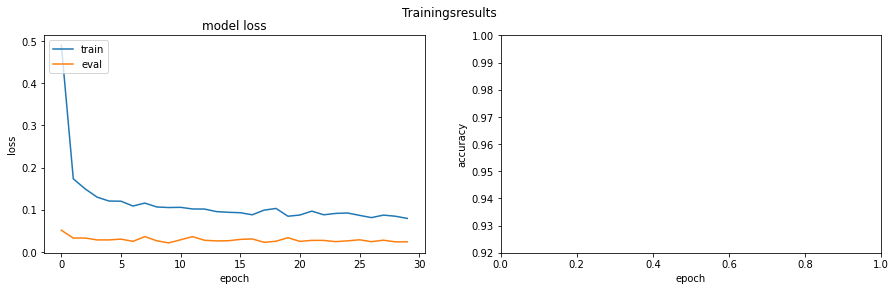

In [5]:
from keras.callbacks import EarlyStopping, LearningRateScheduler, ModelCheckpoint

annealer = LearningRateScheduler(lambda x: 1e-3 * 0.96 ** x, verbose=0)
earlystop = EarlyStopping(monitor='val_loss', mode='min' , patience=50, verbose=1, baseline=0.04, restore_best_weights=True)
mc = ModelCheckpoint(model_filename + '_best.h5', monitor='val_soft_acc', mode='max', verbose=1, save_best_only=True)

history = model.fit(train_iterator, 
                validation_data=validation_iterator, 
                batch_size=Batch_Size, 
                epochs = Epoch_Anz,
                callbacks=[annealer, earlystop, mc],
                verbose=1)

plot_acc_loss(history, "Trainingsresults")

### Validate on all digit meter

Because of the small dataset of meter digits all meter digits are used for validation

390/390 [==============================] - 5s 11ms/step
Tested images: 12477. 1915 false predicted. Accuracy is: 0.8465175923699607


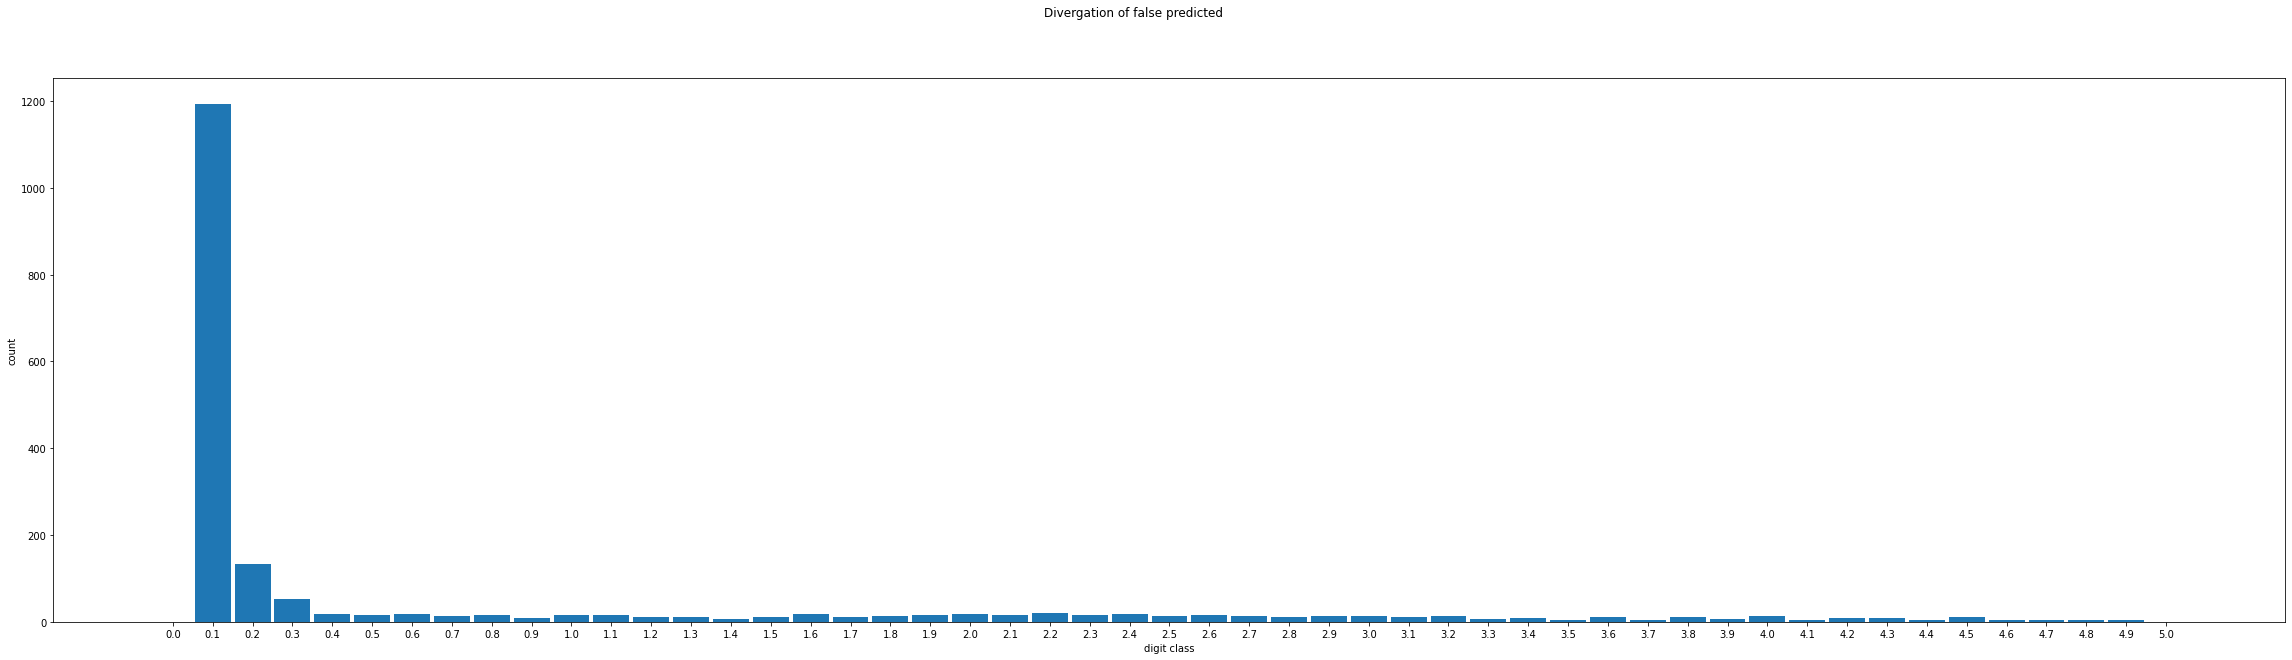

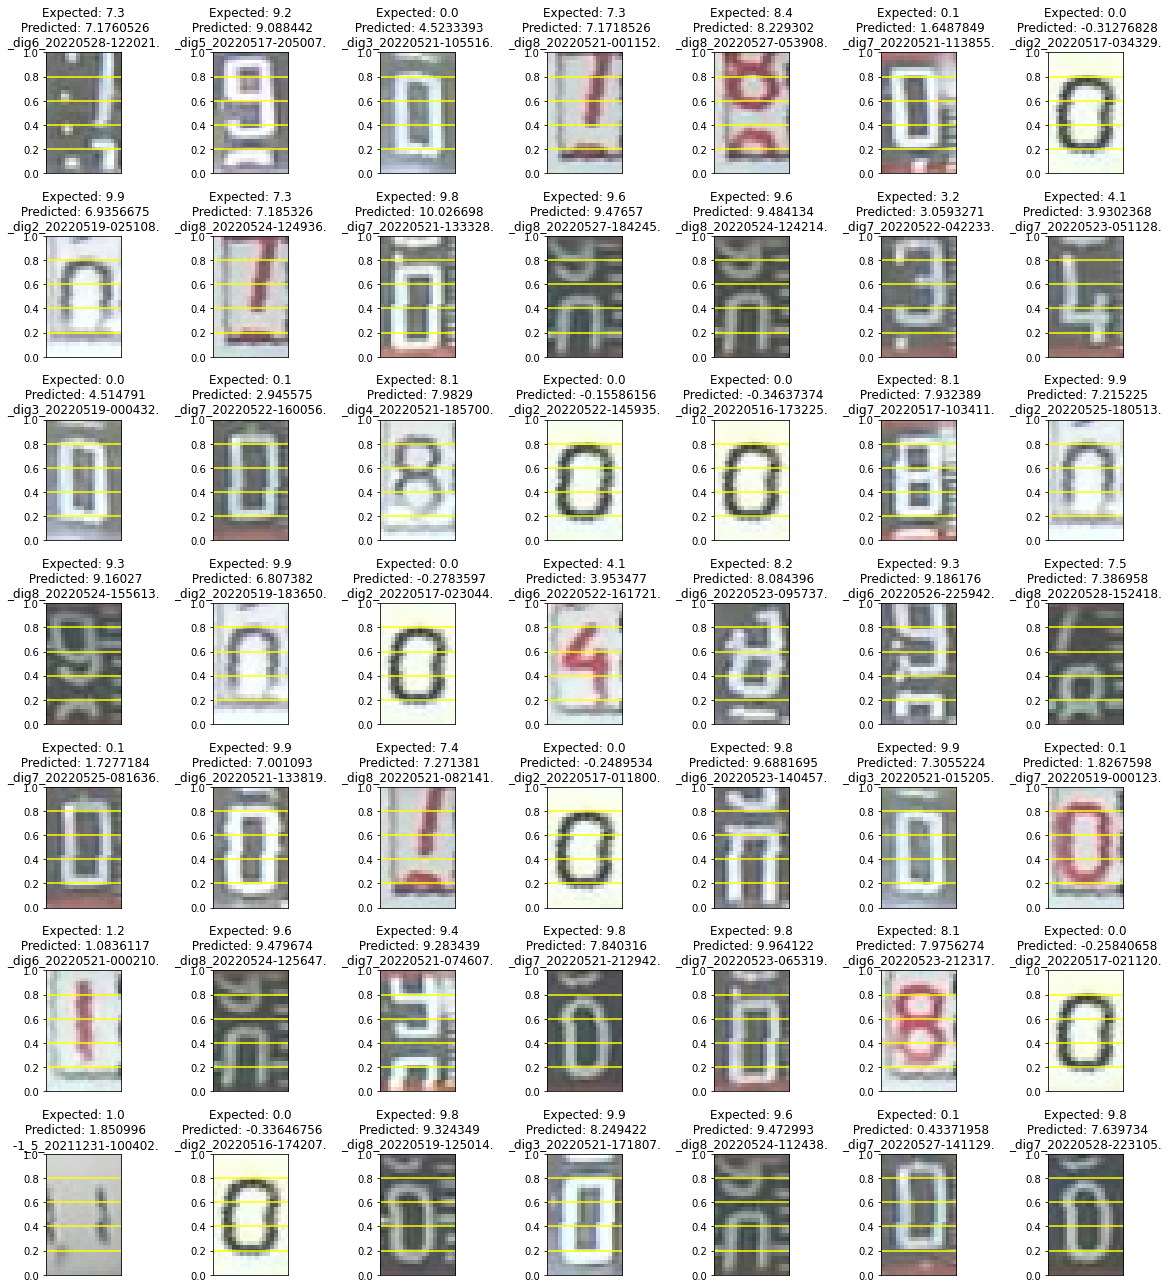

In [6]:
predict_meter_digits(model, x_data=xz_data, y_data=yz_data, f_data=fz_data, classdecoding=class_decoding )

### 2nd train

Now the model will be trained like transfer learning <https://keras.io/guides/transfer_learning/>.

All layers except the top layer will be fixed and not trained in the 2nd training.

As dataset the digit meter images are used.

Train data


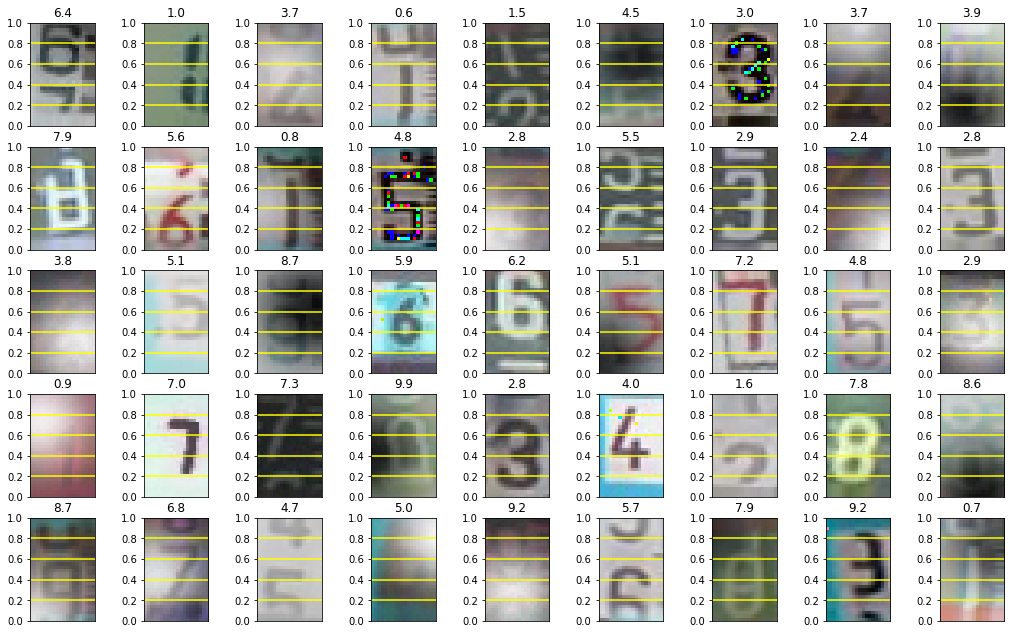

Validation data


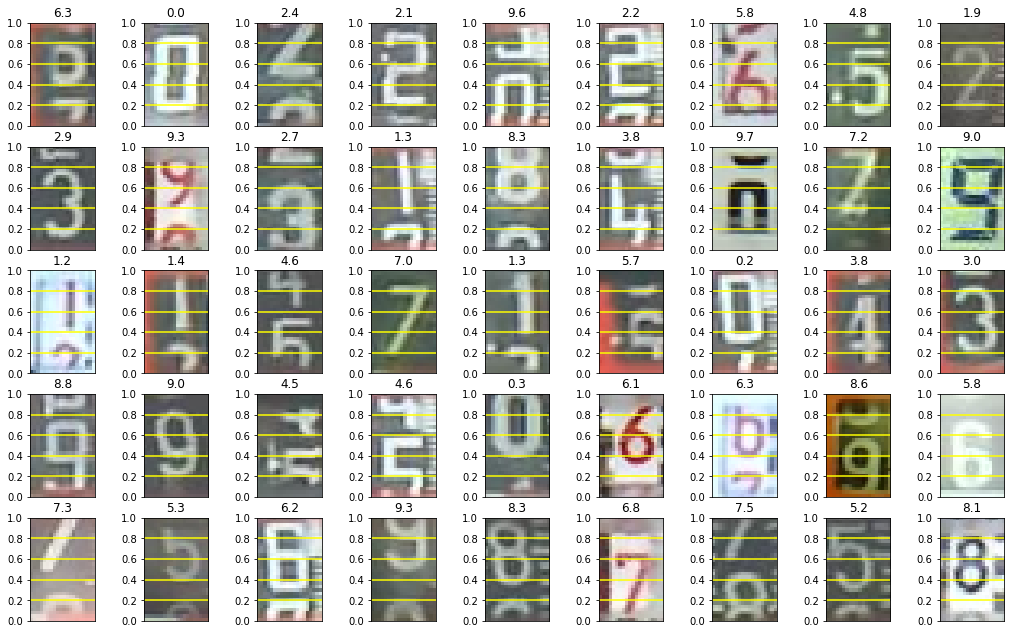

Epoch 1/10
312/312 [==============================] - ETA: 0s - loss: 1.4140 - soft_acc: 0.4526
Epoch 1: val_soft_acc improved from -inf to 0.71915, saving model to output/cnn32-r_best_transfer.h5
312/312 [==============================] - 7s 21ms/step - loss: 1.4140 - soft_acc: 0.4526 - val_loss: 0.3293 - val_soft_acc: 0.7192 - lr: 0.0010
Epoch 2/10
311/312 [============================>.] - ETA: 0s - loss: 1.4045 - soft_acc: 0.4413
Epoch 2: val_soft_acc did not improve from 0.71915
312/312 [==============================] - 6s 20ms/step - loss: 1.4034 - soft_acc: 0.4419 - val_loss: 0.3046 - val_soft_acc: 0.6558 - lr: 9.6000e-04
Epoch 3/10
310/312 [============================>.] - ETA: 0s - loss: 1.4699 - soft_acc: 0.4520
Epoch 3: val_soft_acc did not improve from 0.71915
312/312 [==============================] - 6s 20ms/step - loss: 1.4718 - soft_acc: 0.4512 - val_loss: 0.3938 - val_soft_acc: 0.5485 - lr: 9.2160e-04
Epoch 4/10
310/312 [============================>.] - ETA: 0s - lo

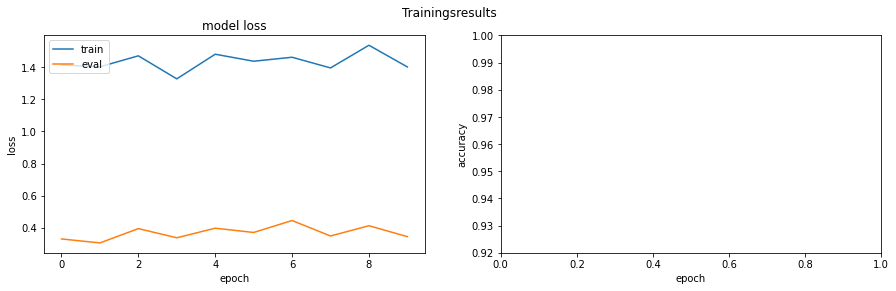

In [9]:
import numpy as np

#model = keras.models.load_model(model_filename + '_best.h5')

# now whith meter digits
train_iterator = augmentation(xz_train, yz_train)
validation_iterator = no_augmentation(xz_test, yz_test)

# train data
print("Train data")
plot_dataset_it(train_iterator, nb_classes=nb_classes, classdecoding=class_decoding)     

# validation data
print("Validation data")
plot_dataset_it(validation_iterator, nb_classes=nb_classes, classdecoding=class_decoding) 

# only the last layer is now trainable
for layer in model.layers[:-3]:
    layer.trainable=False

mc = ModelCheckpoint(model_filename + '_best_transfer.h5', monitor='val_soft_acc', mode='max', verbose=1, save_best_only=True)

model.compile(loss="mse", 
              optimizer="adam", metrics = [soft_acc])

history = model.fit(train_iterator, 
                validation_data=validation_iterator, 
                batch_size=Batch_Size, 
                epochs = 10,
                callbacks=[annealer, earlystop, mc],
                verbose=1)


model.save("model_filename" + "_dist_transfer.h5")

plot_acc_loss(history, "Trainingsresults")


### Validate on all digit meter

Because of the small dataset of meter digits all meter digits are used for validation

390/390 [==============================] - 5s 13ms/step
Tested images: 12477. 11926 false predicted. Accuracy is: 0.044161256712350716


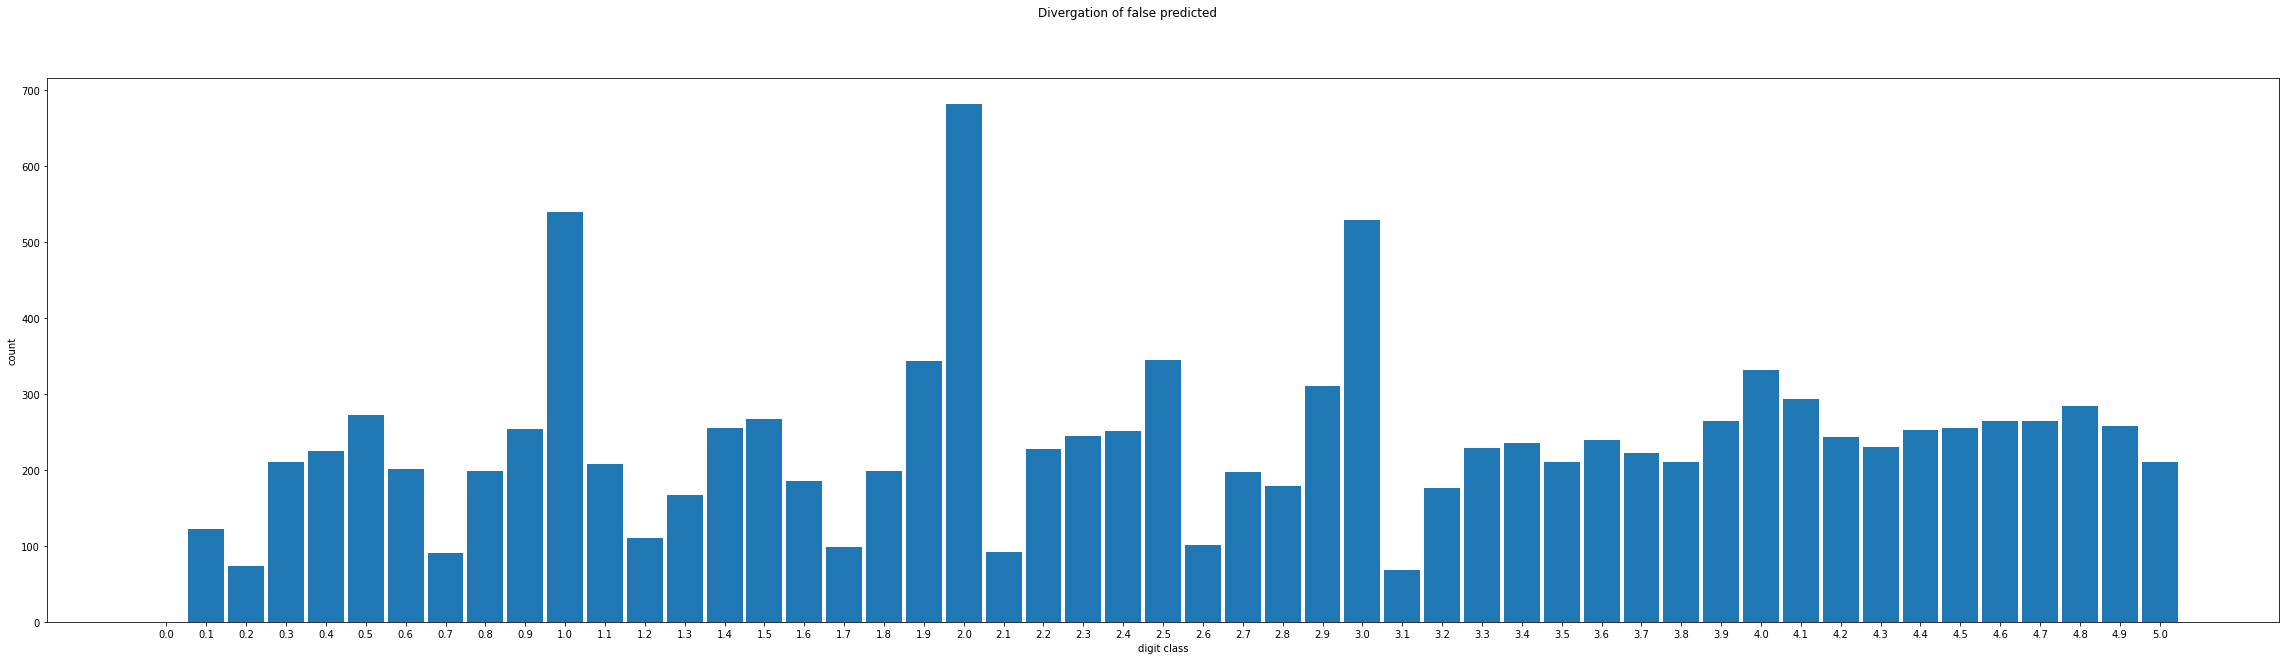

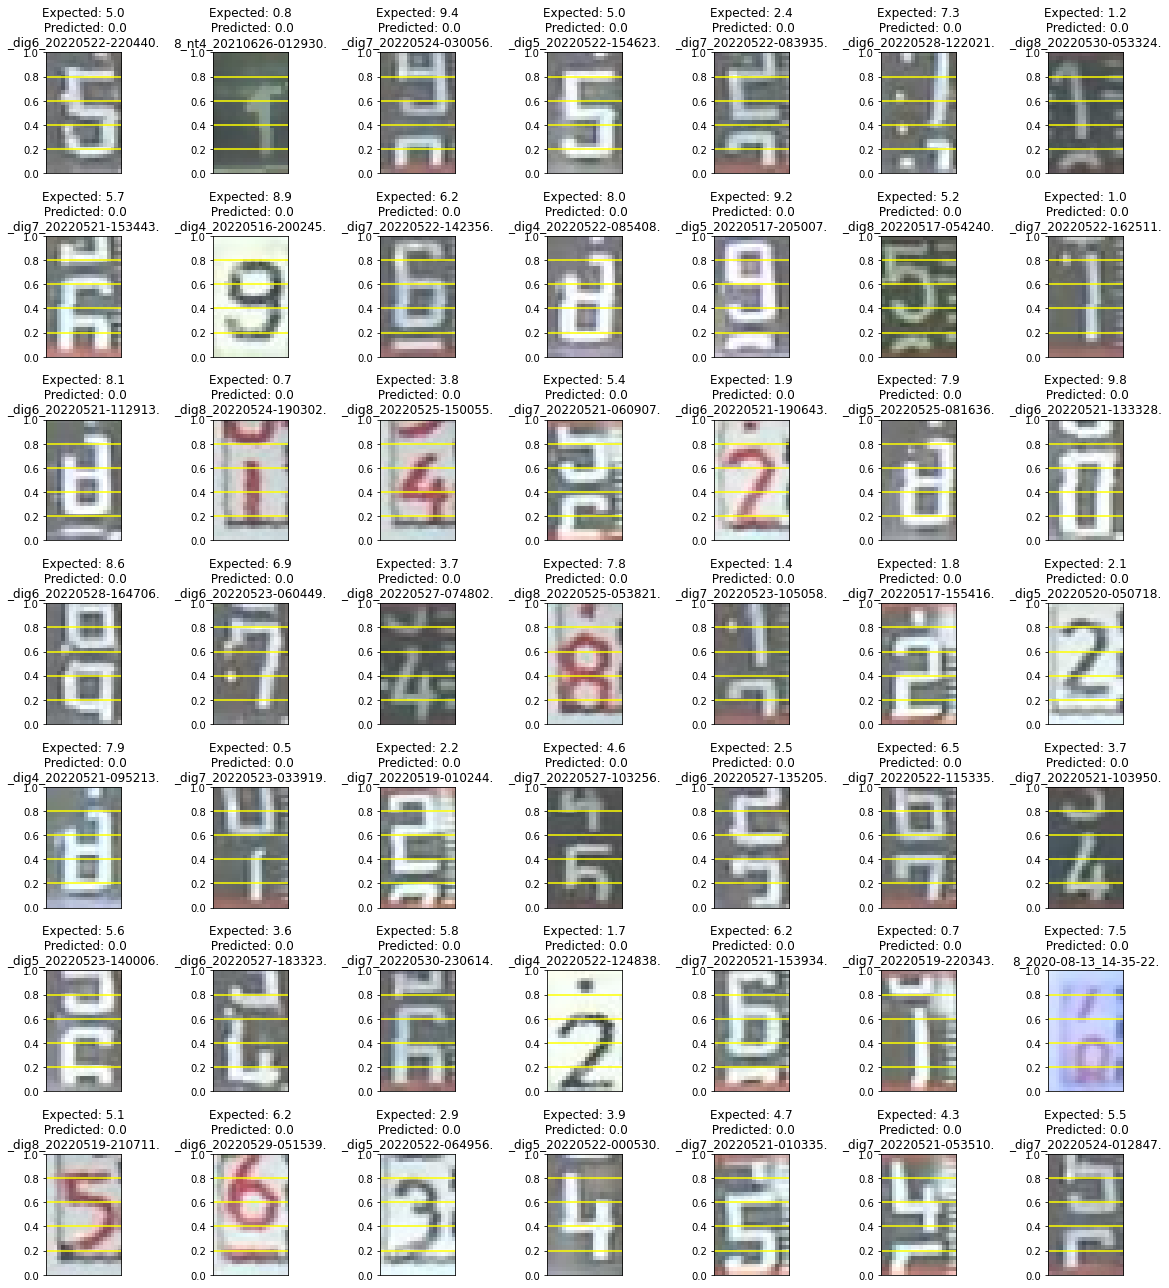

In [8]:
predict_meter_digits(model, x_data=xz_data, y_data=yz_data, f_data=fz_data)